In [142]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import glob
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'axes.unicode_minus': False})
plt.rcParams['font.sans-serif'] = ['Arial']  # 使用无警告字体

In [143]:
# 读取所有 CSV 文件
file_list = glob.glob('../../data/Window_Ads/*.csv')

for i in range(len(file_list)):
    url = file_list[i]
    
    # 提取文件名（去掉路径）
    file_name = Path(file_list[i]).stem  # 获取 '2025.01.22'

    # 替换文件名中的 '.' 为 '-' (防止干扰日期解析)
    formatted_date = file_name.replace('.', '-')

    try:
        # 将格式化后的日期字符串转换为日期对象
        day = pd.to_datetime(formatted_date, format='%Y-%m-%d').day_name()
    except ValueError:
        day = 'Invalid Date'  # 如果解析失败，标记为无效日期

    # 存储到字典格式
    file_list[i] = {day: url}

print(file_list)

[{'Wednesday': '../../data/Window_Ads/2025.01.22.csv'}, {'Thursday': '../../data/Window_Ads/2025.01.23.csv'}, {'Friday': '../../data/Window_Ads/2025.01.24.csv'}, {'Saturday': '../../data/Window_Ads/2025.01.25.csv'}, {'Sunday': '../../data/Window_Ads/2025.01.26.csv'}]


In [144]:
# 按小时顺序排序（手动定义时间段顺序）
hour_order = [
    '12 am – 1 am', '1 am – 2 am', '2 am – 3 am', '3 am – 4 am',
    '4 am – 5 am', '5 am – 6 am', '6 am – 7 am', '7 am – 8 am',
    '8 am – 9 am', '9 am – 10 am', '10 am – 11 am', '11 am – 12 pm',
    '12 pm – 1 pm', '1 pm – 2 pm', '2 pm – 3 pm', '3 pm – 4 pm',
    '4 pm – 5 pm', '5 pm – 6 pm', '6 pm – 7 pm', '7 pm – 8 pm',
    '8 pm – 9 pm', '9 pm – 10 pm', '10 pm – 11 pm', '11 pm – 12 am'
]

Workdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

Workdays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Workdays]
Workdays = pd.concat(Workdays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Workdays['Impressions'] = pd.to_numeric(Workdays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Workdays['Avg. CPC'] = Workdays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Workdays['Cost'] = Workdays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 提取不需要归一化的 'Hour' 列
hour_column = Workdays['Hour']

# 选择需要归一化的数值列（排除非数值列）
numeric_columns = Workdays.select_dtypes(include=['number']).columns

# 进行归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
Workdays_scaled = scaler.fit_transform(Workdays[numeric_columns])

# 将归一化后的数据转换回 DataFrame，并保留 'Hour' 列
Workdays_scaled_df = pd.DataFrame(Workdays_scaled, columns=numeric_columns)
Workdays_scaled_df.insert(0, 'Hour', hour_column)  # 插入原始 Hour 列

Workdays = Workdays_scaled_df

Workdays




,Hour,Clicks,Impressions,Avg. CPC,Cost
0,12 am – 1 am,0.000000,0.011696,0.000000,0.000000
1,1 am – 2 am,0.034884,0.017544,0.551020,0.037465
2,2 am – 3 am,0.034884,0.064327,0.714286,0.048566
3,3 am – 4 am,0.011628,0.073099,0.265306,0.006013
4,4 am – 5 am,0.011628,0.046784,0.612245,0.013876
...,...,...,...,...,...
67,7 pm – 8 pm,0.000000,0.055556,0.000000,0.000000
68,8 pm – 9 pm,0.034884,0.040936,0.387755,0.025902
69,9 pm – 10 pm,1.000000,0.000000,0.510204,0.983349
70,10 pm – 11 pm,0.081395,0.213450,0.612245,0.095745


In [145]:
# 避免除零问题的平滑常数
epsilon = 1e-6

# 计算最大值，防止除以零或极端情况
max_clicks = Workdays['Clicks'].max() + epsilon
max_impressions = Workdays['Impressions'].max() + epsilon
max_cpc = Workdays['Avg. CPC'].max() + epsilon
max_cost = Workdays['Cost'].max() + epsilon

# 改进评分公式，增加对数缩放，减少极端值影响
Workdays['Score'] = (
    np.log1p(Workdays['Clicks'] / (Workdays['Impressions'] + epsilon)) * 
    ((Workdays['Clicks'] + epsilon) / max_clicks + (Workdays['Impressions'] + epsilon) / max_impressions) * 
    ((max_cpc + epsilon) / (Workdays['Avg. CPC'] + epsilon)) * 
    ((max_cost + epsilon) / (Workdays['Cost'] + epsilon))
)

# 处理无穷大和缺失值
Workdays.replace([np.inf, -np.inf], np.nan, inplace=True)
Workdays.dropna(subset=['Score'], inplace=True)

# 确保小时的格式完整，不进行 24 小时转换
Workdays_grouped = Workdays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean',
    'Score': 'mean'
}).reset_index()

Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 显示最终结果
print(Workdays_grouped)

             Hour    Clicks  Impressions  Avg. CPC      Cost      Score
6    12 am – 1 am  0.031008     0.073099  0.217687  0.023898   6.905982
0     1 am – 2 am  0.058140     0.062378  0.374150  0.037774   7.157118
8     2 am – 3 am  0.034884     0.055556  0.482993  0.032840   3.738572
10    3 am – 4 am  0.015504     0.074074  0.224490  0.011101   3.802385
12    4 am – 5 am  0.031008     0.082846  0.687075  0.037003   1.690023
14    5 am – 6 am  0.023256     0.062378  0.326531  0.020506  13.310894
16    6 am – 7 am  0.023256     0.042885  0.231293  0.016035   4.103439
18    7 am – 8 am  0.011628     0.027290  0.163265  0.005859   7.713950
20    8 am – 9 am  0.007752     0.015595  0.272109  0.006167   2.689301
22   9 am – 10 am  0.011628     0.034113  0.285714  0.009559   2.201222
2   10 am – 11 am  0.019380     0.038012  0.129252  0.014801   1.526530
4   11 am – 12 pm  0.011628     0.023392  0.374150  0.008480   6.198742
7    12 pm – 1 pm  0.007752     0.027290  0.285714  0.006475   5

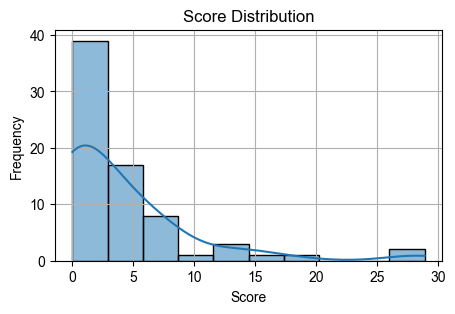

In [146]:
plt.figure(figsize=(5, 3))
sns.histplot(Workdays['Score'], bins=10, kde=True)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [147]:
threshold = 8

Workdays['Tag'] = 0
Workdays.loc[Workdays['Score'] >= threshold, 'Tag'] = 1

In [148]:
X = Workdays[['Clicks', 'Impressions', 'Avg. CPC', 'Cost', 'Score']]
y = Workdays['Tag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = scaler.fit_transform(X_train)


In [149]:
# 定义参数网格
param_grid = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.001, 0.005, 0.01, 0.1, 0.2],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.8, 1.0]
}

# 初始化XGBoost分类器
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# 进行网格搜索
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 获取最佳参数和最佳得分
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


({'colsample_bytree': 1.0,
  'learning_rate': 0.2,
  'max_depth': 1,
  'n_estimators': 10,
  'subsample': 0.6},
 np.float64(1.0))

In [150]:
from sklearn.preprocessing import LabelEncoder

# 对 Hour 进行编码
Workdays['Hour_encoded'] = LabelEncoder().fit_transform(Workdays['Hour'])
print(Workdays)
# 选择特征，移除字符串列
X = Workdays[['Clicks', 'Impressions', 'Avg. CPC', 'Cost', 'Score', 'Hour_encoded']]
y = Workdays['Tag'].astype(int)

# 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练 XGBoost 模型
best_xgb_model = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric='logloss'
)

best_xgb_model.fit(X_train, y_train)

# 进行预测
y_pred = best_xgb_model.predict(X_test)
# print(y_pred)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


             Hour    Clicks  Impressions  Avg. CPC      Cost      Score  Tag  \
0    12 am – 1 am  0.000000     0.011696  0.000000  0.000000   0.000000    0   
1     1 am – 2 am  0.034884     0.017544  0.551020  0.037465   2.780096    0   
2     2 am – 3 am  0.034884     0.064327  0.714286  0.048566   1.239090    0   
3     3 am – 4 am  0.011628     0.073099  0.265306  0.006013   7.838976    0   
4     4 am – 5 am  0.011628     0.046784  0.612245  0.013876   1.526152    0   
..            ...       ...          ...       ...       ...        ...  ...   
67    7 pm – 8 pm  0.000000     0.055556  0.000000  0.000000   0.000000    0   
68    8 pm – 9 pm  0.034884     0.040936  0.387755  0.025902   4.652714    0   
69   9 pm – 10 pm  1.000000     0.000000  0.510204  0.983349  27.536983    1   
70  10 pm – 11 pm  0.081395     0.213450  0.612245  0.095745   1.624872    0   
71  11 pm – 12 am  0.000000     0.000000  0.000000  0.000000   0.000000    0   

    Hour_encoded  
0              6  
1

In [151]:
from sklearn.preprocessing import LabelEncoder

# 先确保训练数据和测试数据的一致性
if 'Hour_encoded' not in Workdays_grouped.columns:
    le = LabelEncoder()
    Workdays_grouped['Hour_encoded'] = le.fit_transform(Workdays_grouped['Hour'])

# 选择相同的特征进行预测
Workdays_grouped_X = Workdays_grouped[['Clicks', 'Impressions', 'Avg. CPC', 'Cost', 'Score', 'Hour_encoded']]

# 将测试集的预测结果加入到数据中
Workdays_grouped_X_pred = best_xgb_model.predict(Workdays_grouped_X)
Workdays_grouped['Predicted_Tag'] = Workdays_grouped_X_pred

# 将时间段信息添加回测试数据（假设索引匹配）
test_indices = Workdays_grouped.index
Workdays_grouped['Hour'] = Workdays_grouped.loc[test_indices, 'Hour']

# 分类优质和垃圾时间段
good_timeline = Workdays_grouped[Workdays_grouped['Predicted_Tag'] == 1]['Hour'].tolist()
good_timeline_score = Workdays_grouped[Workdays_grouped['Predicted_Tag'] == 1]['Score'].tolist()
trash_timeline = Workdays_grouped[Workdays_grouped['Predicted_Tag'] == 0]['Hour'].tolist()
trash_timeline_score = Workdays_grouped[Workdays_grouped['Predicted_Tag'] == 0]['Score'].tolist()
print(good_timeline)
print(good_timeline_score)
print('-' * 50)
print(trash_timeline)
print(trash_timeline_score)
print(len(good_timeline), len(trash_timeline))



['5 am – 6 am', '9 pm – 10 pm']
[13.310894123634247, 10.915389998016584]
--------------------------------------------------
['12 am – 1 am', '1 am – 2 am', '2 am – 3 am', '3 am – 4 am', '4 am – 5 am', '6 am – 7 am', '7 am – 8 am', '8 am – 9 am', '9 am – 10 am', '10 am – 11 am', '11 am – 12 pm', '12 pm – 1 pm', '1 pm – 2 pm', '2 pm – 3 pm', '3 pm – 4 pm', '4 pm – 5 pm', '5 pm – 6 pm', '6 pm – 7 pm', '7 pm – 8 pm', '8 pm – 9 pm', '10 pm – 11 pm', '11 pm – 12 am']
[6.905982388298678, 7.157117651167617, 3.73857192568463, 3.802385044931475, 1.6900228909419164, 4.103439112212569, 7.7139502601378025, 2.689300619011737, 2.2012223632545367, 1.526529742849192, 6.19874159232764, 5.056579946450258, 1.6116028939547202, 2.8869527117487395, 4.374973472561149, 0.0, 0.6037534395205663, 0.0, 4.537939172833877, 3.876742256838116, 0.5416240367157622, 0.0]
2 22


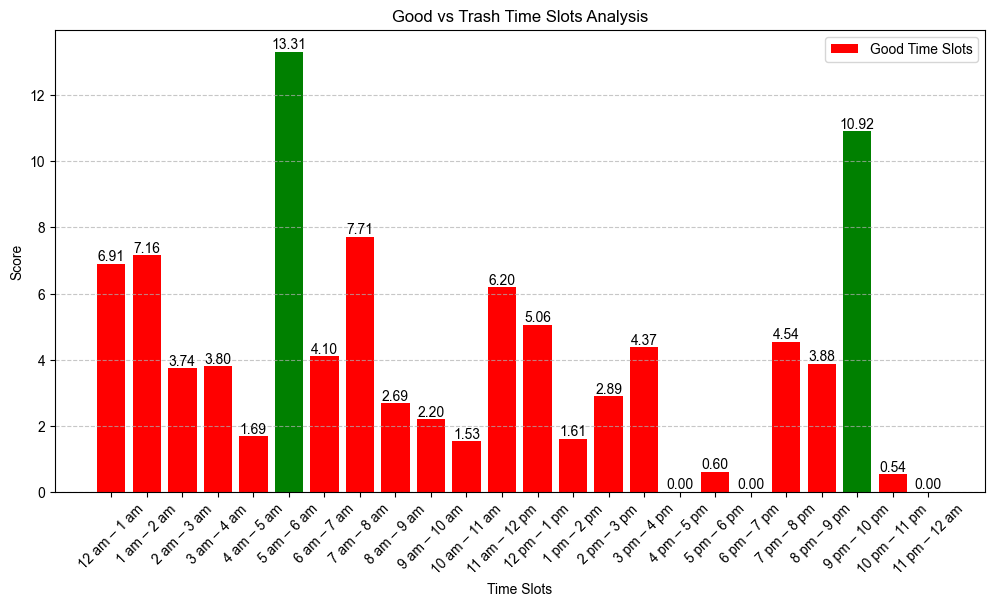

In [152]:
# 设置时间为分类类型，确保排序
Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped_sorted = Workdays_grouped.sort_values('Hour')

# 按预测结果分类
good_sorted = Workdays_grouped_sorted[Workdays_grouped_sorted['Predicted_Tag'] == 1]
trash_sorted = Workdays_grouped_sorted[Workdays_grouped_sorted['Predicted_Tag'] == 0]

good_timeline_sorted = good_sorted['Hour'].tolist()
trash_timeline_sorted = trash_sorted['Hour'].tolist()
good_scores_sorted = good_sorted['Score'].values
trash_scores_sorted = trash_sorted['Score'].values

# 合并优质和垃圾时间段
all_timeline_sorted = good_timeline_sorted + trash_timeline_sorted
all_scores_sorted = np.concatenate((good_scores_sorted, trash_scores_sorted), axis=0)
all_colors = ['green'] * len(good_scores_sorted) + ['red'] * len(trash_scores_sorted)

# 按时间顺序排序
sorted_indices = [hour_order.index(hour) for hour in all_timeline_sorted]
sorted_pairs = sorted(zip(sorted_indices, all_timeline_sorted, all_scores_sorted, all_colors))
sorted_timeline, sorted_scores, sorted_colors = zip(*[(t, s, c) for _, t, s, c in sorted_pairs])

# 创建可视化
plt.figure(figsize=(12, 6))

# 绘制按时间顺序的时间段
bars = plt.bar(sorted_timeline, sorted_scores, color=sorted_colors)

# 在柱状图顶部添加数值标签
for bar, score in zip(bars, sorted_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom', fontsize=10)

# 设置图表标题和标签
plt.title('Good vs Trash Time Slots Analysis')
plt.xlabel('Time Slots')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(['Good Time Slots', 'Trash Time Slots'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.show()